In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

## Data Import: moisture dataset

In [ ]:
data = pd.read_excel("C:\\Users\\Eugenio_Py\\Desktop\\Notebooks\\datasets\\moisture.xlsx", sheet_name=0, header=0)

In [ ]:
data.info()

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
data

In [ ]:
# Checking the missing values
data.isnull().sum()

In [ ]:
data.columns = data.columns.astype(str) # to make the colnames as numeric

In [ ]:
#plot the scatter plot of Moisture and wavelength in data
plt.scatter(data['Moisture'],data['1136'])
plt.xlabel("1136")
plt.ylabel('Moisture')
plt.show()

In [ ]:
# select only numerical attributes
X = data.iloc[:, 1:176]
X

In [ ]:
# Plot the IR spectra
X.T.plot(legend=False,figsize=(16,9));

In [ ]:
wl = np.arange(1104,2497,8) #wavelengths

In [ ]:
wl

In [ ]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [ ]:
X = data.values[:, 1:176]

In [ ]:
Xsnv = snv(X)

In [ ]:
Xsnv

In [ ]:
# Preprocessing with Savitzki-Golay - smoothing
from scipy.signal import savgol_filter
X_savgol = savgol_filter(X, 7, polyorder = 2, deriv=0)

In [ ]:
# Preprocessing with Savitzki-Golay - smoothing and SNV
X_savgol = savgol_filter(X, 7, polyorder = 2, deriv=0)
X_snv_savgol = snv(X_savgol)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(15,15))
#fig, axs = plt.subplots(2, 2, figsize=(15,15))
ax1.plot(wl,  X.T)
ax1.set_title('Original data')
ax2.plot(wl,  Xsnv.T)
ax2.set_title('SNV')
ax3.plot(wl,  X_savgol.T)
ax3.set_title('Savitzki-Golay - smoothing')
ax4.plot(wl,  X_snv_savgol.T)
ax4.set_title('Savitzki-Golay - smoothing + SNV')

## Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA

# Define the PCA object
pca = PCA()
 
# Run PCA producing the reduced variable Xreg and select the first 10 components
pca = PCA(n_components=10)
Xreg = pca.fit_transform(X_snv_savgol)

In [ ]:
# Define y for PCR and PLS regressions
y = data.Moisture
y.head()

In [ ]:
# PCA scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

4 components seems a proper number

In [ ]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
   
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

In [ ]:
# Cumulative explained variance ratio
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Prop. Variance Explained')
plt.show()

In [ ]:
# Run PCA producing the reduced variable Xreg with a proper number of components
pca = PCA(n_components=3)
Xreg = pca.fit_transform(X_snv_savgol)

In [ ]:
# Prepare the data for the scores
scores = pd.DataFrame(data = Xreg, columns = ['PC1', 'PC2', 'PC3'])

# Scores - for graphs
scores = pd.concat([scores, y], axis = 1)

scores.head()

In [ ]:
# Loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=data.columns[1:176])
loadings["Wavelengths"] = wl
loadings

In [ ]:
#Scores plot
import plotly.express as px
fig = px.scatter(scores, x="PC1", y="PC2", hover_data={'Sample': (scores.index)})
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_layout(
    height=600,
    width=800,
    title_text='Scores Plot')
fig.show()

In [ ]:
#Scores plot
import plotly.express as px
fig = px.scatter(scores, x="PC1", y="PC2", color="Moisture", hover_data={'Sample': (scores.index)})
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_layout(
    height=600,
    width=800,
    title_text='Scores Plot')
fig.show()

In [ ]:
fig = px.scatter(loadings, x="PC1", y="PC2",text="Wavelengths")
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    width=800,
    title_text='Loadings Plot')
fig.show()

In [ ]:
fig = px.line(loadings, x="Wavelengths", y="PC1")
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    width=800,
    title_text='Loadings Plot')
fig.show()

## Principal Component Regression (PCR)

In [ ]:
# Define y for regression
y = data.Moisture

In [ ]:
scores

In [ ]:
# Define X for regression
scores = scores.iloc[:,0:3]
scores.head()

In [ ]:
from sklearn import linear_model

# Create linear regression object 
regr = linear_model.LinearRegression() 
# Fit 
regr.fit(scores, y)

In [ ]:
# Calibration 
y_c = regr.predict(scores) 

In [ ]:
# Cross-validation 
from sklearn.model_selection import cross_val_predict
y_cv = cross_val_predict(regr, scores, y, cv=10) # k-fold of 10, random selection

In [ ]:
# Calculate r2 for calibration and cross-validation 
from sklearn.metrics import mean_squared_error, r2_score
r2_calibration = r2_score(y, y_c) 
r2_cv = r2_score(y, y_cv)

In [ ]:
# Calculate mean square error for calibration and cross validation 
mse_c = mean_squared_error(y, y_c) 
mse_cv = mean_squared_error(y, y_cv)

In [ ]:
print(r2_calibration, r2_cv, mse_c, mse_cv)

In [ ]:
def pcr(X,y,pc):
    pca = PCA()
    Xreg = pca.fit_transform(X)[:,:pc]
    regr = linear_model.LinearRegression()
    regr.fit(Xreg, y)
    y_c = regr.predict(Xreg)
    y_cv = cross_val_predict(regr, Xreg, y, cv=10)
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

In [ ]:
pcr(X_snv_savgol,y,10)

In [ ]:
pcr(X_snv_savgol,y,3)

In [ ]:
pcr(X_snv_savgol,y,4)

In [ ]:
predicted, r2r, r2cv, mser, mscv = pcr(X_snv_savgol,y, pc=4)
 
# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('$R^{2}$ (CV): '+str(round(r2cv,4)))
    plt.xlabel('Measured Moisture')
    plt.ylabel('Predicted Moisture')
    plt.show()

The green line represents the ideal, 100%, correlation between measured and predicted values. The blue line is the actual correlation.  With R^{2}=0.9... the result is great, but a number of other things are required to improve this figure. Things about multiplicative scatter correction and feature selection are often used to improve the prediction. At the same time, the main limitation of the PCR approach (the fact the PCA is done without knowledge of the y values) also plays a big role in the final results.

Typically, better results can be obtained with Partial Least Squares (PLS).

In [ ]:
predicted

In [ ]:
predicted

In [ ]:
np.array(y)

In [ ]:
my_residuals = predicted - np.array(y)

In [ ]:
my_residuals

In [ ]:
my_residuals = pd.DataFrame(my_residuals, columns = ['pcr_residuals'])

In [ ]:
import seaborn as sns
sns.kdeplot(data=my_residuals, x="pcr_residuals");

## Partial Least Squares (PLS) regression

PLS, acronym of Partial Least Squares, is a widespread regression technique used to analyse near-infrared spectroscopy data. If you know a bit about NIR spectroscopy, you sure know very well that NIR is a secondary method and NIR data needs to be calibrated against primary reference data of the parameter one seeks to measure. This calibration must be done the first time only. Once the calibration is done, and is robust, one can go ahead and use NIR data to predict values of the parameter of interest.

Both PLS and PCR perform multiple linear regression, that is they build a linear model, Y=XB+E. Using a common language in statistics, X is the predictor and Y is the response. In NIR analysis, X is the set of spectra, Y is the quantity – or quantities- we want to calibrate for. Finally E is an error.

The matrix X contains highly correlated data and this correlationmay obscure the variations we want to measure, that is the variations of the Y content. Both PCR and PLS will get rid of the correlation.

In PCR, the set of measurements X is transformed into an equivalent set X’=XW by a linear transformation W, such that all the new ‘spectra’ (which are the principal components) are linearly independent. In statistics X’ is called the factor scores. The linear transformation in PCR is such that it minimises the covariance between the different rows of X’. That means this process only uses the spectral data, not the response values.

This is the key difference between PCR and PLS regression. PLS is based on finding a similar linear transformation, but accomplishes the same task by maximising the covariance between Y and X’. In other words, PLS takes into account both spectra and response values and in doing so will improve on some of the limitations on PCR. For these reasons PLS is one of the staples of modern chemometrics.

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
 
# Define PLS object
pls = PLSRegression(n_components=10)
 
# Fit
pls.fit(X_snv_savgol, y)

As you can see, sklearn has already got a PLS packagw. So, first we define the number of components we want to keep in our PLS regression. I decided to keep 10 components for the sake of this example, but later will use that as a free parameter to be optimised. Once the PLS object is defined, we fit the regression to the data X (the predictor) and y (the known response). The third step is to use the model we just built to run a cross-validation experiment using 10 folds cross-validation. When we do not have a large number of spectra, cross-validation is a good way to test the predictive ability of our calibration.

To check how good our calibration is, we measure the usual metrics. We’ll evaluate these metrics by comparing the result of the cross-validation y_cv with the known responses. To optimise the parameters of our PLS regression (for instance pre-processing steps and number of components) we’ll just track those metrics, most typically the MSE.

In [ ]:
# Cross-validation
y_cv = cross_val_predict(pls, X_snv_savgol, y, cv=3)
 
# Calculate scores
pls_r2 = r2_score(y, y_cv)
mse = mean_squared_error(y, y_cv)

In [ ]:
mse

In [ ]:
pls_r2

In [ ]:
X = data.values[:, 1:176]

In [ ]:
# Calculate second derivative
X2 = savgol_filter(X, 7, polyorder = 2,deriv=2)

In [ ]:
# Plot second derivative
plt.figure(figsize=(15,15))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.show()

The offset is gone and the data look more bunched together.

Now it’s time to get to the optimisation of the PLS regression. As anticipated above, we want to run a PLS regression with a variable number of components and test its performance in cross-validation. In practice we want to find the number of components that minimises the MSE.

In [ ]:
from sys import stdout

In [ ]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
 
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(round(score_cv,4)))
        plt.xlabel('Predicted $^{\circ}$')
        plt.ylabel('Measured $^{\circ}$')
 
        plt.show()
 
    return

This function first runs a loop over the number of PLS components and calculates the MSE of prediction.  Secondly, it finds the number of components that minimises the MSE and uses that value to run a PLS again. A bunch of metrics is calculated and printed the second time around.

Let’s run this function by setting the maximum number of components to 5.

In [ ]:
optimise_pls_cv(X_snv_savgol,y, 20, plot_components=True)

The first plot that’ll come up is the MSE as a function of the number of components. The suggested number of components that minimises the MSE is highlighted on the plot.

The second plot is the actual regression figure, including the metrics for the prediction.

The model seems to work well on both calibration and validation data!

We can try to optimize it using a variable selection approach

In [ ]:
pls_opt = PLSRegression(n_components=3)
pls_opt.fit(X_snv_savgol, y)

In [ ]:
pls_opt.x_scores_

In [ ]:
# Scores
scores = pd.DataFrame(data = pls_opt.x_scores_, columns = ['LV1', 'LV2', 'LV3'])

# Scores - for graphs
scores = pd.concat([scores, y], axis = 1)

scores.head()

In [ ]:
#Scores
pls_opt.x_loadings_

In [ ]:
# Loadings
loadings = pd.DataFrame(pls_opt.x_loadings_,columns=['LV1', 'LV2', 'LV3'], index=data.columns[1:176])
loadings["Wavelengths"] = wl
loadings

In [ ]:
#Scores plot
import plotly.express as px
fig = px.scatter(scores, x="LV1", y="LV2", color="Moisture", hover_data={'Sample': (scores.index)})
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_layout(
    height=600,
    width=800,
    title_text='Scores Plot')
fig.show()

In [ ]:
#Loadings plot
fig = px.line(loadings, x="Wavelengths", y="LV1")
# fig = px.scatter(loadings, x="LV1", y="LV2",hover_data={'Wavelength': (loadings.Wavelengths)})
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=600,
    width=800,
    title_text='Loadings Plot')
fig.show()

In [ ]:
# Plot variables
plt.figure(figsize=(16,16))
with plt.style.context(('ggplot')):
    plt.plot(wl, X[(0,38),:].T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.legend(['0', '38'])
    plt.show()

In [ ]:
Y_pred = pls_opt.predict(X_snv_savgol)

In [ ]:
Y_pred

In [ ]:
np.array(y)

In [ ]:
np.array(Y_pred)

In [ ]:
np.concatenate(Y_pred)

In [ ]:
my_residuals = np.concatenate(Y_pred)-np.array(y)

In [ ]:
my_residuals

In [ ]:
my_residuals = pd.DataFrame(my_residuals, columns = ['pls_residuals'])

In [ ]:
import seaborn as sns
sns.kdeplot(data=my_residuals, x="pls_residuals");

## Variable selection method for PLS

The idea behind variable selection in chemometrics is that when it comes to spectral measurements not all wavelengths are created equals. In visible and NIR spectroscopy especially, it is often hard to predict in advance which wavelength bands will contain most of the signal related to the analyte we want to measure. So, as a first shot, we measure the whole range allowed by our instrument, and then figure out later which bands are more relevant for our calibration.

To say the same thing in a bit more quantitative way, we want to check which wavelength bands lead to a better quality model. Actually, in practice, we check which bands give a worse quality model, so we can get rid of them.

### Feature selection by filtering

Feature selection by filtering is one of the simplest ways of performing wavelength selection.

The idea behind this method is very simple, and can be summarised in the following:

 - Optimise the PLS regression using the full spectrum, for instance using cross-validation or prediction data to quantify its quality.
 - Extract the regression coefficients form the best model. Each regression coefficient uniquely associates each wavelength with the response. A low absolute value of the regression coefficient means that specific wavelength has a low correlation with the quantity of interest.
 - Discard the lowest correlation wavelengths according to some rule. These wavelengths are the ones that typically worsen the quality of the calibration model, therefore by discarding them effectively we expect to improve the metrics associated with our prediction or cross-validation.

One way to discard the lowest correlation wavelengths is to set a threshold and get rid of all wavelengths whose regression coefficients (in absolute value) fall below that threshold. However this method is very sensitive to the choice of threshold, which tends to be a subjective choice, or requires a trial-and-error approach.

Another approach, that is much less subjective, is to discard one wavelength at a time (the one with the lowest absolute value of the associated regression coefficient) and rebuild the calibration model. By choosing the MSE (means square error) of prediction or cross-validation as metric, the procedure is iterated until the MSE decreases. At some point, removing wavelengths will produce a worse calibration, and that is the stopping criterion for the optimisation algorithm.

Alternatively, one could simply remove a fixed number of wavelengths iteratively, and then check for which number of removed wavelengths the MSE is minimised. Either way we have a method that does not depend on the subjective choice of the threshold and can be applied without changes regardless of the data set being analysed.

One caveat of this method, at least in its simple implementation is that it may get a bit slow for large datasets.

In [ ]:
from sys import stdout
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
loadings

In [ ]:
# Define the PLS regression object
pls = PLSRegression(n_components=3)
# Fit data
pls.fit(X_snv_savgol, y)
 
# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X_snv_savgol.T)
    plt.ylabel('My data')
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(loadings.LV1))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of Loadings LV1')
 
    plt.show()

What we have done is a basic PLS regression with *n* components and used it to fit the first derivative data. The PLS coefficients of this fit can be accessed by pls Loadings, that is the first (and in this case only) column of the pls.coef_ object. It is worth reiterating that these are the regression coefficients that quantify the strength of the association between each wavelength and the response. We are interested only in the absolute value of these coefficients, as large positive and large negative coefficients are equally important for our regression, denoting large positive or large negative correlation with the response respectively. In other words we want to identify and discard the regression coefficients that are close to zero: they are the ones with poor correlation with the response.

The association between each coefficient and the spectral feature can be visualised using the the second part of the code above, producing this plot.

As you can see, a number of wavelengths are associated with fairly small regression coefficients. We want to use this basic idea to identify and discard small coefficients iteratively, starting from the smallest, and optimise the PLS regression at the same time.

In [ ]:
# Get the list of indices that sorts the PLS coefficients in ascending order 
# of the absolute value
sorted_ind = np.argsort(np.abs(loadings.LV1))
 
# Sort spectra according to ascending absolute value of PLS coefficients
Xc = X_snv_savgol[:,sorted_ind]
Xc

What we have done is to extract the sequence of indices corresponding to sorting the absolute value of the PLS regression coefficients in ascending order, and use that sequence to sort the spectra accordingly. Note that sorting the spectral component according to the strength of the associated PLS coefficients has no influence whatsoever on the PLS regression, but it enables us to easily discard one component at a time.

In [ ]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(loadings.LV1))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(loadings.LV1))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

The following function function works by running a PLS regression with a given number of components (up to a specified maximum), then filtering out one regression coefficient at a time up to the maximum number allowed. All data are stored in the 2D array mse. At the end of the double loop we search for the global minimum of mse excluding the zeros. That will give us the number of components and the wavelength bands that corresponds to the optimal cross-validation MSE.

To give you an idea of the huge improvement we can get with this approach, let’s compare the result obtained using the full spectrum with the one optimised by variable selection. We start by defining a function to perform simple PLS with a fixed number of components, and calculate the metrics in cross-validation.

In [ ]:
def simple_pls_cv(X, y, n_comp):
 
    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression 
 
    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_cv, y, c='red', edgecolors='k')
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        
        plt.show()

In [ ]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X_snv_savgol, y, 3)
simple_pls_cv(opt_Xc, y, 3)

As a sanity check, we can plot the discarded bands on top of the absorbance spectra. The code is as follows.

In [ ]:
# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wl.ravel(), wl[sorted_ind][:wav])
 
import matplotlib.collections as collections
 
# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax.plot(wl, X_snv_savgol.T)
    plt.ylabel('First derivative absorbance spectra')
    plt.xlabel('Wavelength (nm)')
 
collection = collections.BrokenBarHCollection.span_where(
    wl, ymin=-2, ymax=2, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)
 
plt.show()

## Outlier detection - works for PCA, PCR and PLS

In [ ]:
# Define PLS object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X_snv_savgol, y)
 
# Get X scores
T = pls.x_scores_
# Get X loadings
P = pls.x_loadings_

In [ ]:
# Calculate error array
Err = X_snv_savgol - np.dot(T,P.T)
Err

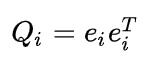

In [ ]:
# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)

In [ ]:
Q

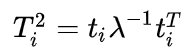

lambda is a diagonal matrix containing the eigenvalues corresponding to k principal components, factors, or latent variables retained in the model.

In [ ]:
# Calculate Hotelling's T-squared (data are normalised here - i.e., divided by std)
Tsq = np.sum((pls.x_scores_/np.std(pls.x_scores_, axis=0))**2, axis=1)

In [ ]:
Tsq

In [ ]:
ncomp = 3

In [ ]:
# set the confidence level
conf = 0.95
 
from scipy.stats import f
# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=X_snv_savgol.shape[0])*ncomp*(X_snv_savgol.shape[0]-1)/(X_snv_savgol.shape[0]-ncomp)
 

In [ ]:
Tsq_conf

In [ ]:
i = np.max(Q)+1

In [ ]:
i

In [ ]:
while (1 - np.sum(Q > i)/np.sum(Q > 0)) > conf:
    i -= 1
    Q_conf = i

In [ ]:
Q_conf

In [ ]:
# Plot the Q vs Hotelling T2
import matplotlib.pyplot as plt
ax = plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')
 
    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')
 
plt.show()

In [ ]:
residuals = {'Hotelling T2': Tsq,
        'Q residuals': Q
        }
residuals = pd.DataFrame(residuals)
residuals

In [ ]:
residuals.max()

In [ ]:
residuals.sort_values('Q residuals')